# NN draw

In [1]:
import jax
import numpy as np
from time import time
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from jaxopt import ProjectedGradient

In [2]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)
colors = sns.color_palette()

## The model objective function

In [5]:
class TrueMLP(nn.Module):
    n_hidden: int = 50

    def setup(self):
        self.hidden_1 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.hidden_2 = nn.Dense(50,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

        self.last = nn.Dense(1,
            bias_init=nn.initializers.normal(1.0),
            kernel_init=nn.initializers.normal(1.0),
        )

    def __call__(self, x):
        x = self.hidden_1(x)
        x = nn.relu(x)
        x = self.hidden_2(x)
        x = nn.relu(x)
        x = self.last(x)
        return x

In [6]:
key = jax.random.PRNGKey(3141)
key_init, key_run = jax.random.split(key)

In [7]:
dim = 200 # change to 200
X_init = jnp.ones((1, dim))

base_model = TrueMLP()
params_base = base_model.init(key_init, X_init)

In [8]:
def objective_fn(x):
    return -base_model.apply(params_base, x)

In [9]:
def plot_hist(ax, runs, color=None, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    color_plot = "black" if color is None else color
    color_fill = "tab:gray" if color is None else color
    
    ax.plot(med_run, c=color_plot, **kwargs)
    ax.fill_between(steps, lbound, ubound, color=color_fill, alpha=0.4)

## Best optimum (projected gradient descent)

In [10]:
opt = ProjectedGradient(
    fun=lambda x: -base_model.apply(params_base, x).squeeze(),
    projection=partial(eval_fn.projection, lbound=0.0, ubound=1.0),  # Enforce boundary constraints
    stepsize=1e-7,
    maxiter=8000
)

guess_init = jax.random.uniform(key_run, dim) # intial guess per run
res = opt.run(init_params=guess_init)

In [11]:
yopt = base_model.apply(params_base, res.params)
yopt

Array([1765.5752], dtype=float32)

## Low-rank Kalman filter (LRKF)

In [12]:
n_runs = 10

In [13]:
agent, bel_init_fn = agents.load_lrkf_agent(
    X_init, rank=50, cov=1.0, obs_noise=0.1, dynamics_cov=1, low_rank_diag=False,
)

In [14]:
%%time
n_steps = 600
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
bel, runs_lrkf = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)

CPU times: user 22.1 s, sys: 132 ms, total: 22.2 s
Wall time: 14.8 s


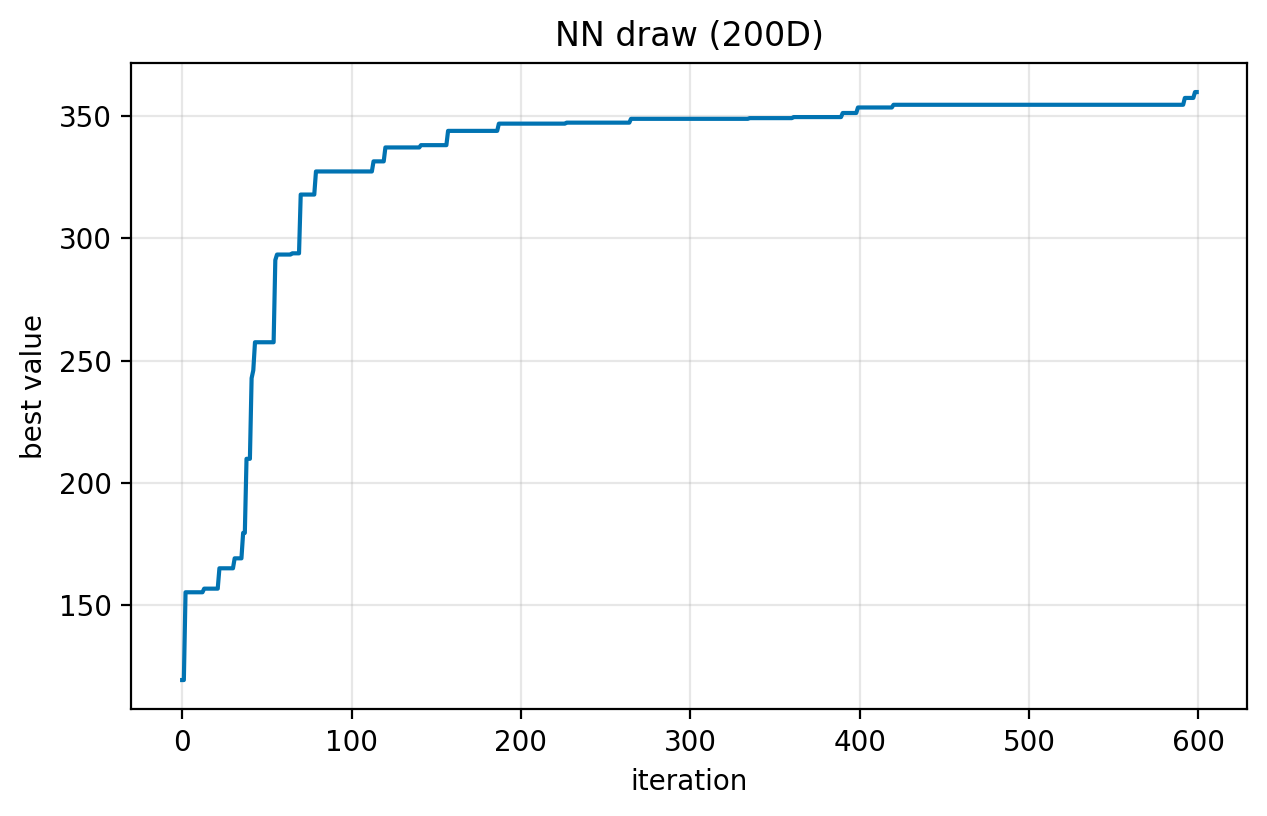

In [15]:
fig, ax = plt.subplots()
ax.plot(runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

In [38]:
agent, bel_init_fn = agents.load_lrkf_agent(
    X_init, rank=50, cov=1.0, obs_noise=0.1, dynamics_cov=1, low_rank_diag=False,
)

In [39]:
%%time
time_init = time()
n_steps = 600
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_lrkf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)
time_lrkf = time() - time_init

CPU times: user 25.6 s, sys: 458 ms, total: 26.1 s
Wall time: 22.8 s


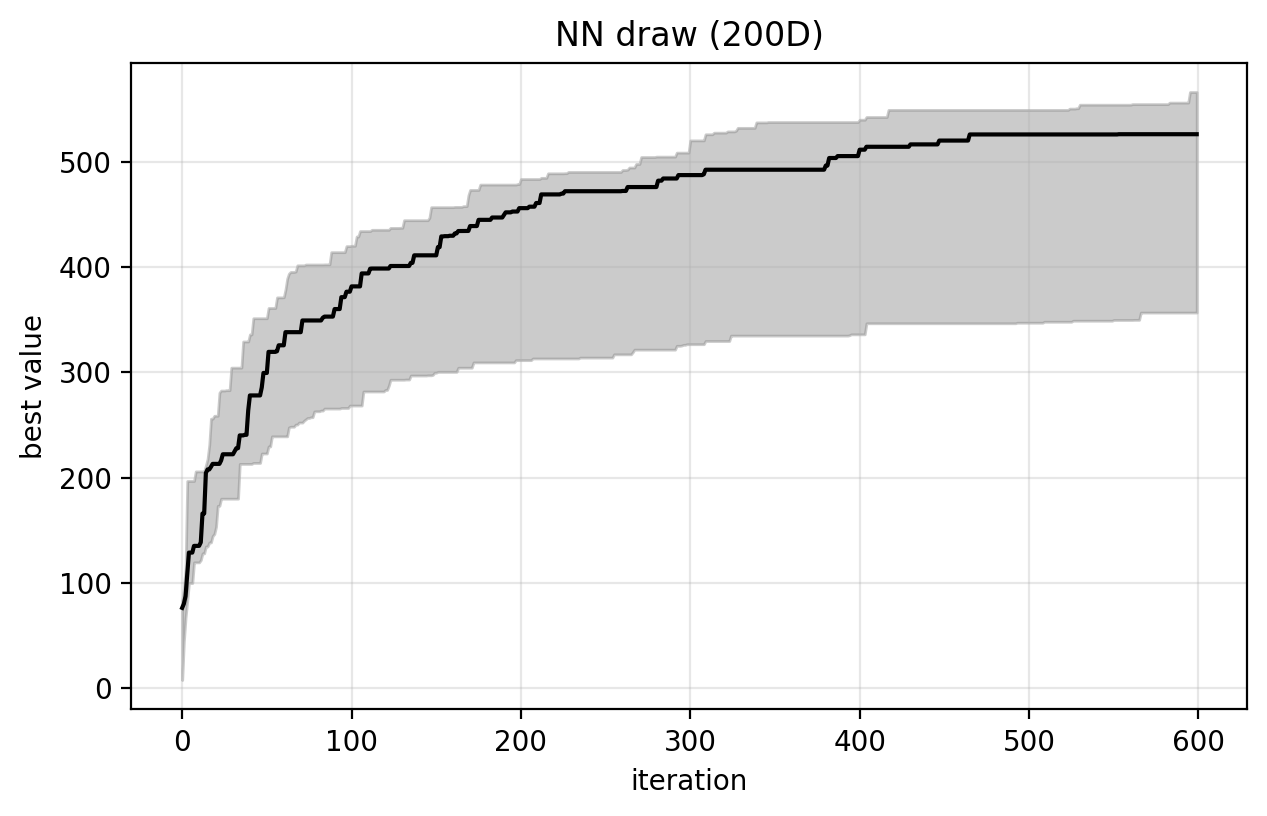

In [40]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## LL-LRKF

In [19]:
agent, bel_init_fn = agents.load_ll_lrkf_agent(
    X_init, rank=50, cov_hidden=1e-4, cov_last=0.01, dynamics_last=1e-6,
)

In [20]:
%%time
time_init = time()
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_l3rkf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_l3rkf = jax.tree.map(np.array, runs_l3rkf)
time_l3rkf = time() - time_init

CPU times: user 33.5 s, sys: 443 ms, total: 34 s
Wall time: 25.7 s


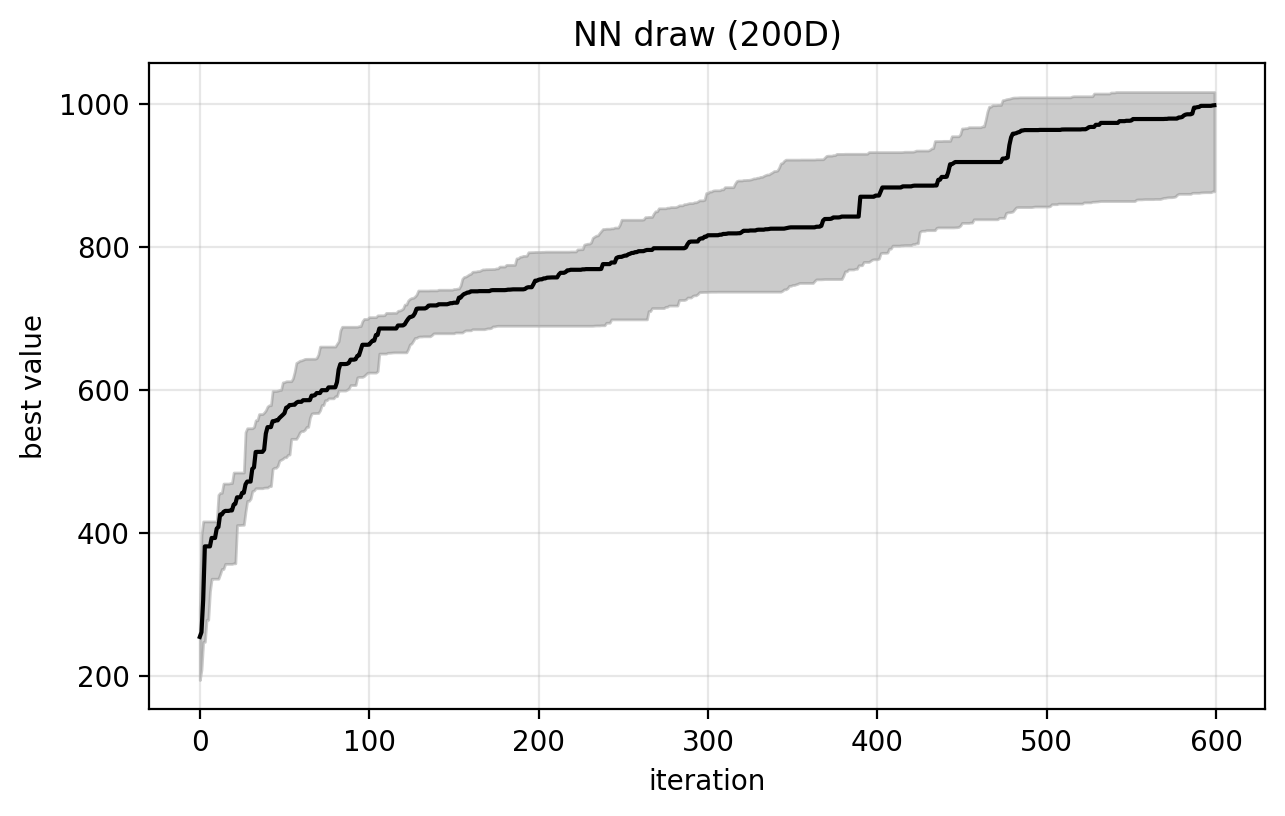

In [21]:
fig, ax = plt.subplots()
plot_hist(ax, runs_l3rkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Run multiple dims

In [22]:
%%time
ranks = [1, 10, 20, 50, 100, 150]
n_steps = 600
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
for rank in ranks:
    print(rank, end="\r")
    
    agent, bel_init_fn = agents.load_ll_lrkf_agent(
        X_init, rank=rank, cov_hidden=1e-4, cov_last=0.01,
    )    

    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
    runs = jax.tree.map(np.array, runs)
    runs_all[rank] = runs

CPU times: user 4min 58s, sys: 7.41 s, total: 5min 5s
Wall time: 3min 47s


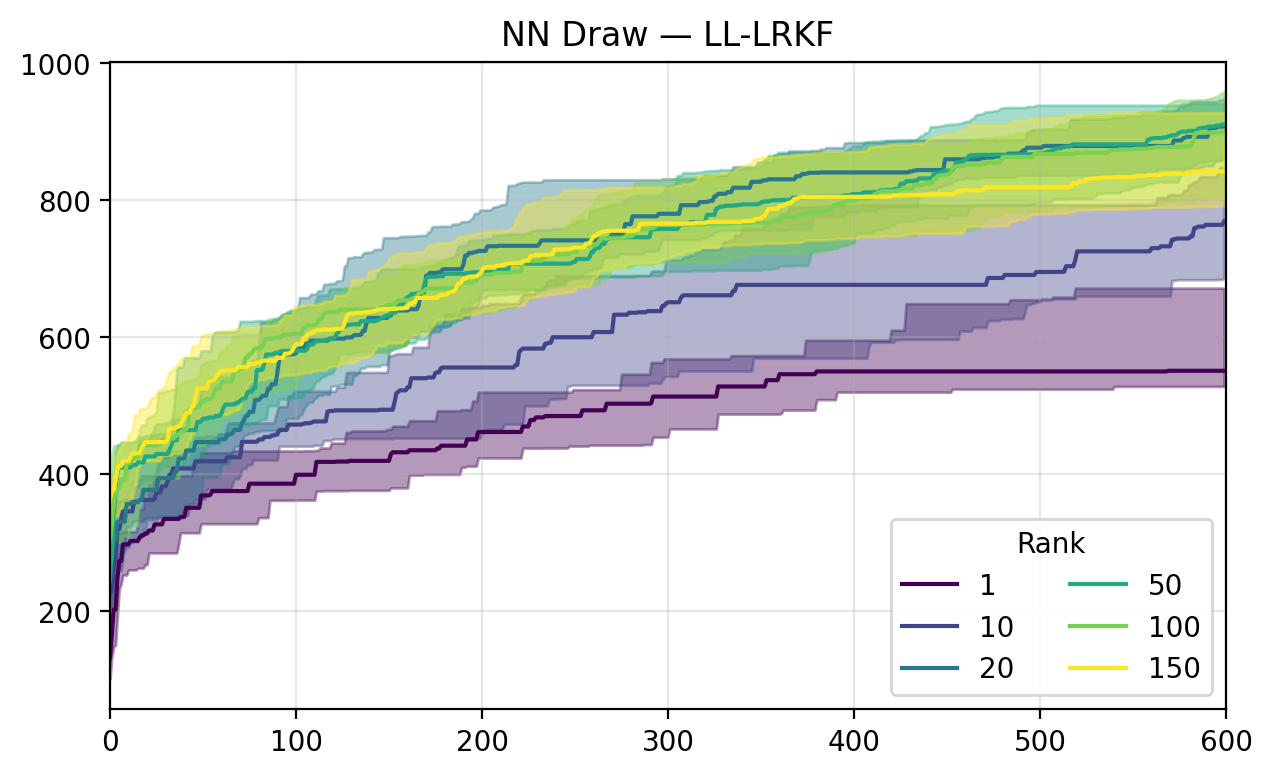

In [23]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, rank in zip(colors, ranks):
    plot_hist(ax, runs_all[rank]["y_best"], color=color, label=rank)
plt.legend(title="Rank", ncols=2)
# plt.ylim(bottom=800)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.grid(alpha=0.3)

## Run multiple noise terms

In [24]:
%%time

ll_cov_init = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
rank = 10
n_steps = 600
n_runs = 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
for cfg in ll_cov_init:
    print(cfg, end="\r")
    
    agent, bel_init_fn = agents.load_ll_lrkf_agent(
        X_init, rank=rank, cov_hidden=1e-4, cov_last=cfg,
    )    

    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
    runs = jax.tree.map(np.array, runs)
    runs_all[cfg] = runs

CPU times: user 4min 34s, sys: 8.23 s, total: 4min 42s
Wall time: 3min 53s


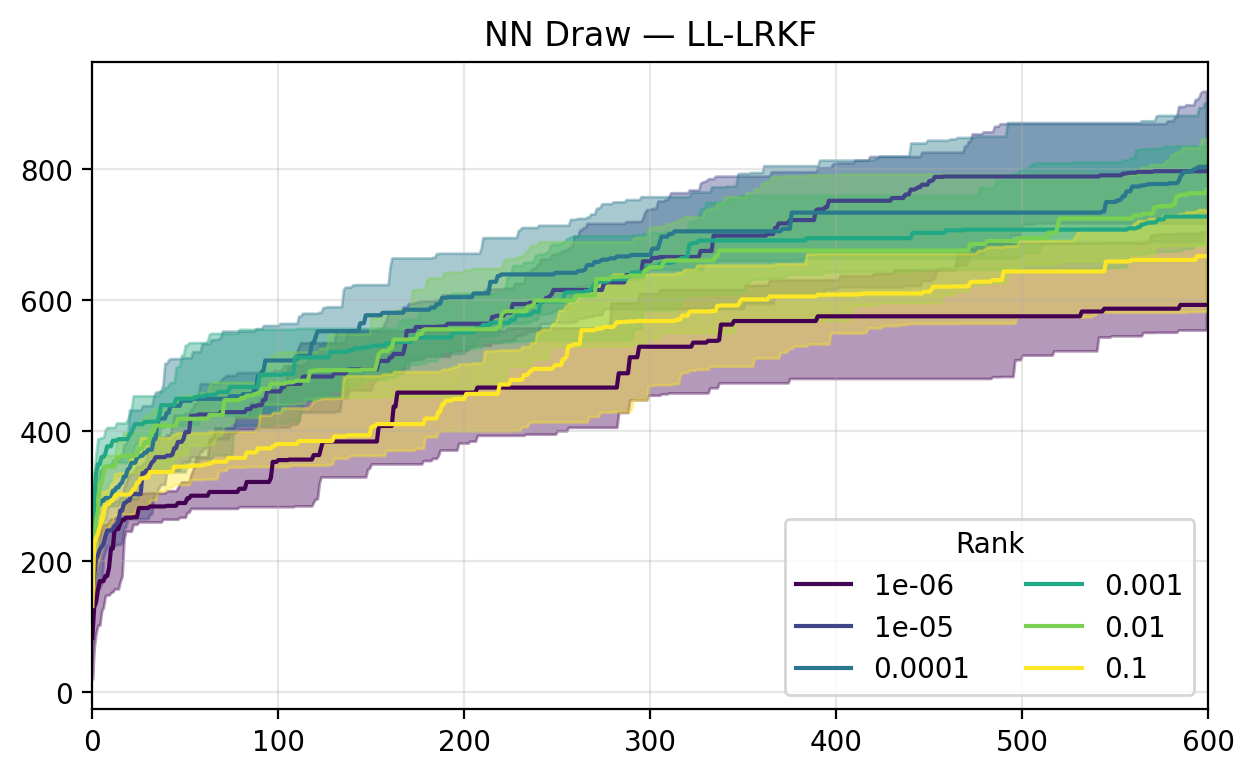

In [25]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, cfg in zip(colors, ll_cov_init):
    plot_hist(ax, runs_all[cfg]["y_best"], color=color, label=cfg)
plt.legend(title="Rank", ncols=2)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.grid(alpha=0.3)

## LoFi

In [26]:
rank = 50
agent, bel_init_fn = agents.load_lofi_agent(
    X_init, rank=rank, cov_init=1e-6, obs_noise=1.0, dynamics_covariance=1e-5
)

In [27]:
%%time
n_steps = 600
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
bel, runs_lrkf = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)

CPU times: user 27 s, sys: 733 ms, total: 27.8 s
Wall time: 17.6 s


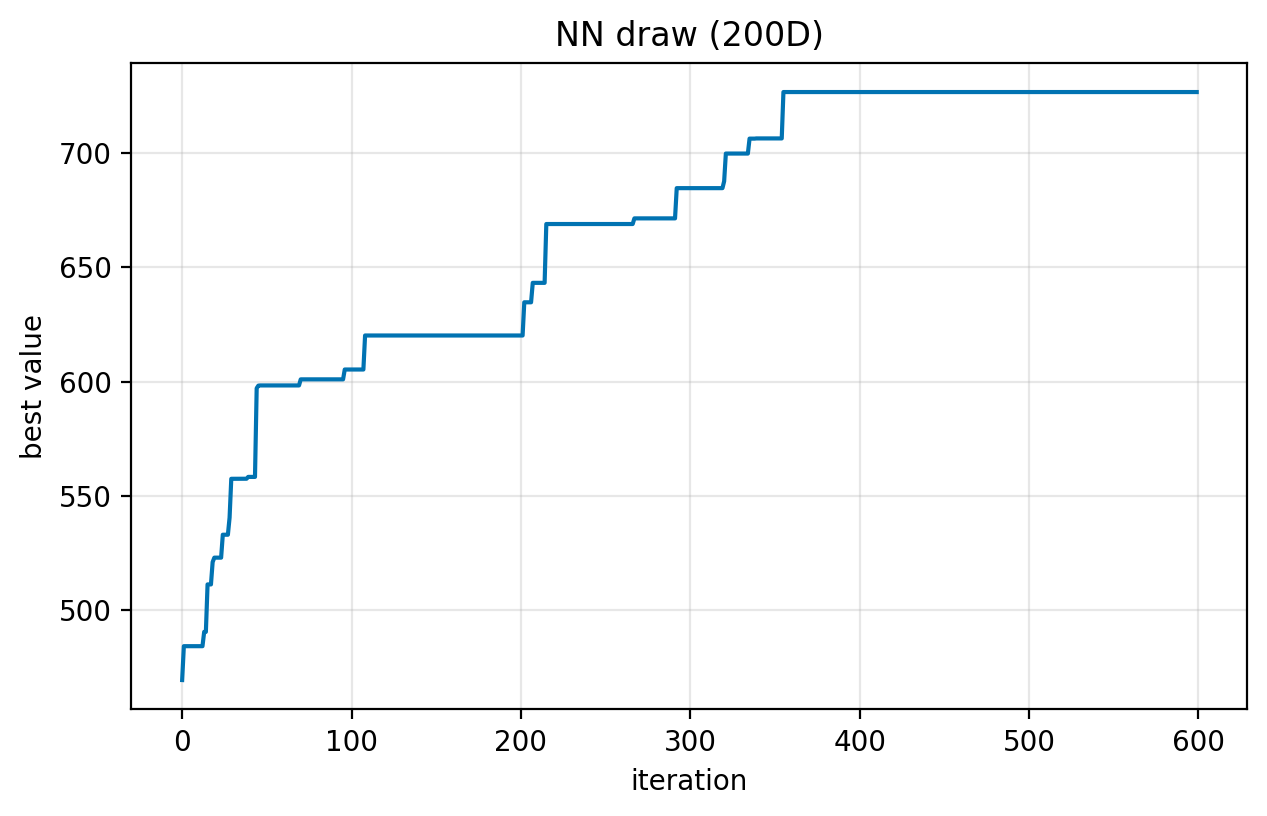

In [28]:
fig, ax = plt.subplots()
ax.plot(runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

In [29]:
%%time
time_init = time()
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_lofi = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
runs_lofi = jax.tree.map(np.array, runs_lofi)
time_lofi = time() - time_init

CPU times: user 44.6 s, sys: 1.64 s, total: 46.2 s
Wall time: 1min 38s


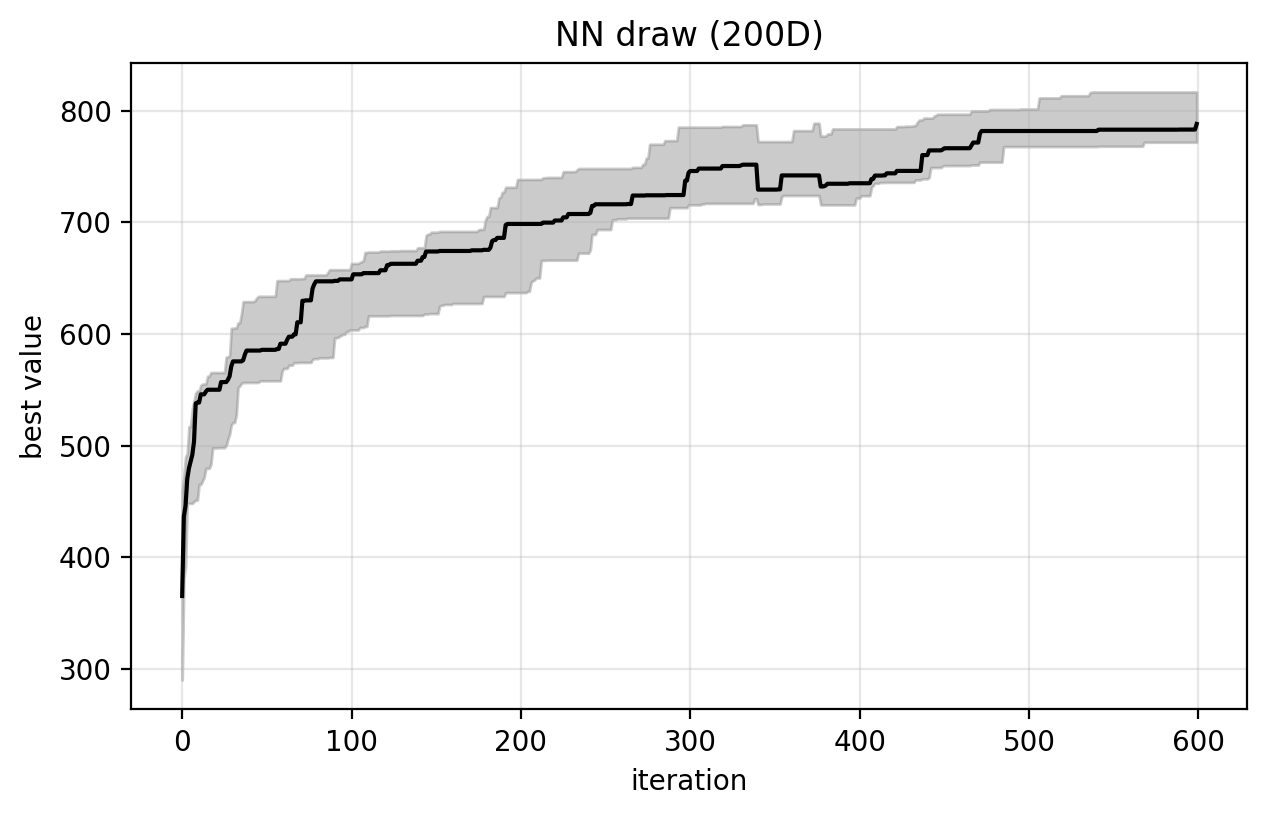

In [30]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lofi["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## LoFi - no dynamics / low rank only

In [31]:
rank = 50
agent, bel_init_fn = agents.load_lofi_agent(
    X_init, rank=rank, cov_init=1e-7, obs_noise=1.0, dynamics_covariance=0.0
)

In [32]:
%%time
n_steps = 600
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
bel, runs_lrkf = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
)
runs_lrkf = jax.tree.map(np.array, runs_lrkf)

CPU times: user 24.2 s, sys: 332 ms, total: 24.5 s
Wall time: 20.8 s


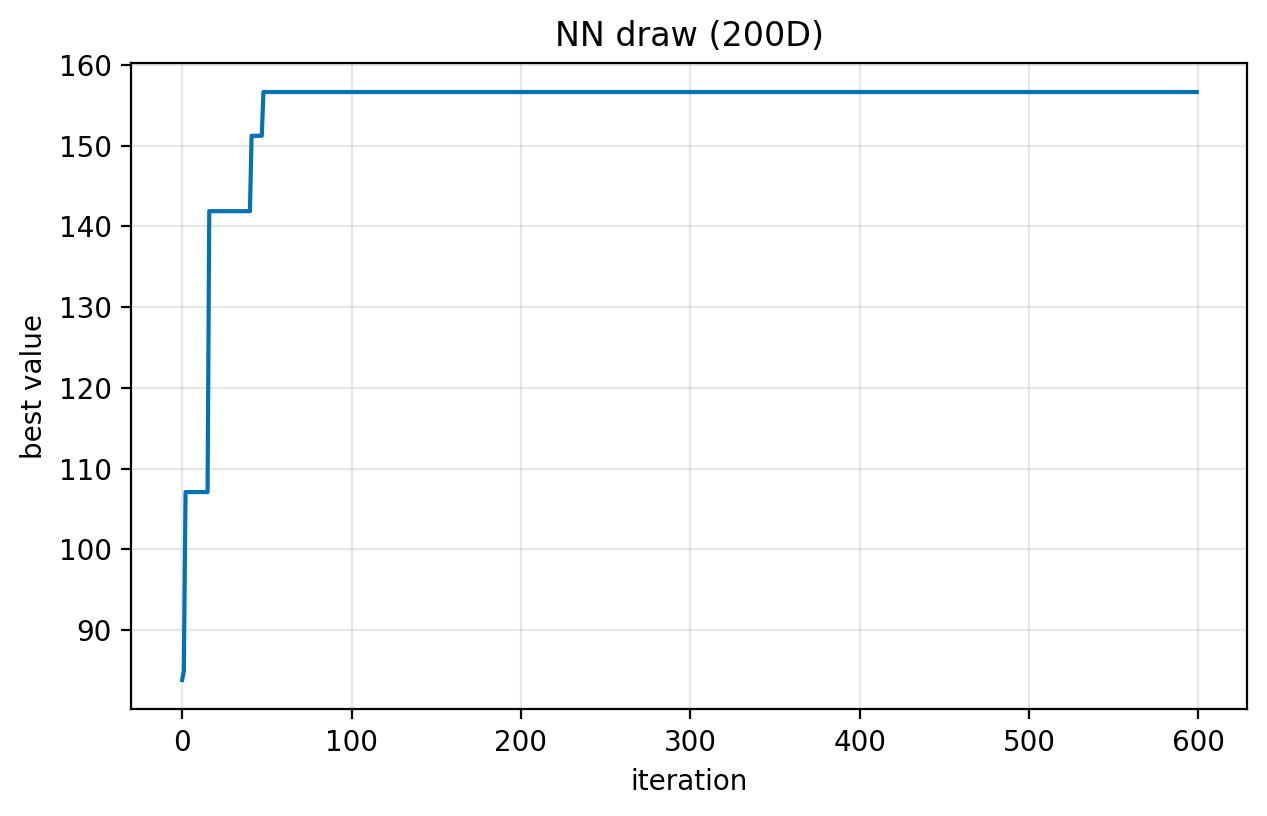

In [33]:
fig, ax = plt.subplots()
ax.plot(runs_lrkf["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

In [34]:
%%time
time_init = time()
n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs_lofi_null = eval_fn.test_runs(keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim)
runs_lofi_null = jax.tree.map(np.array, runs_lofi_null)
time_lofi_null = time() - time_init

CPU times: user 39.9 s, sys: 909 ms, total: 40.8 s
Wall time: 1min 36s


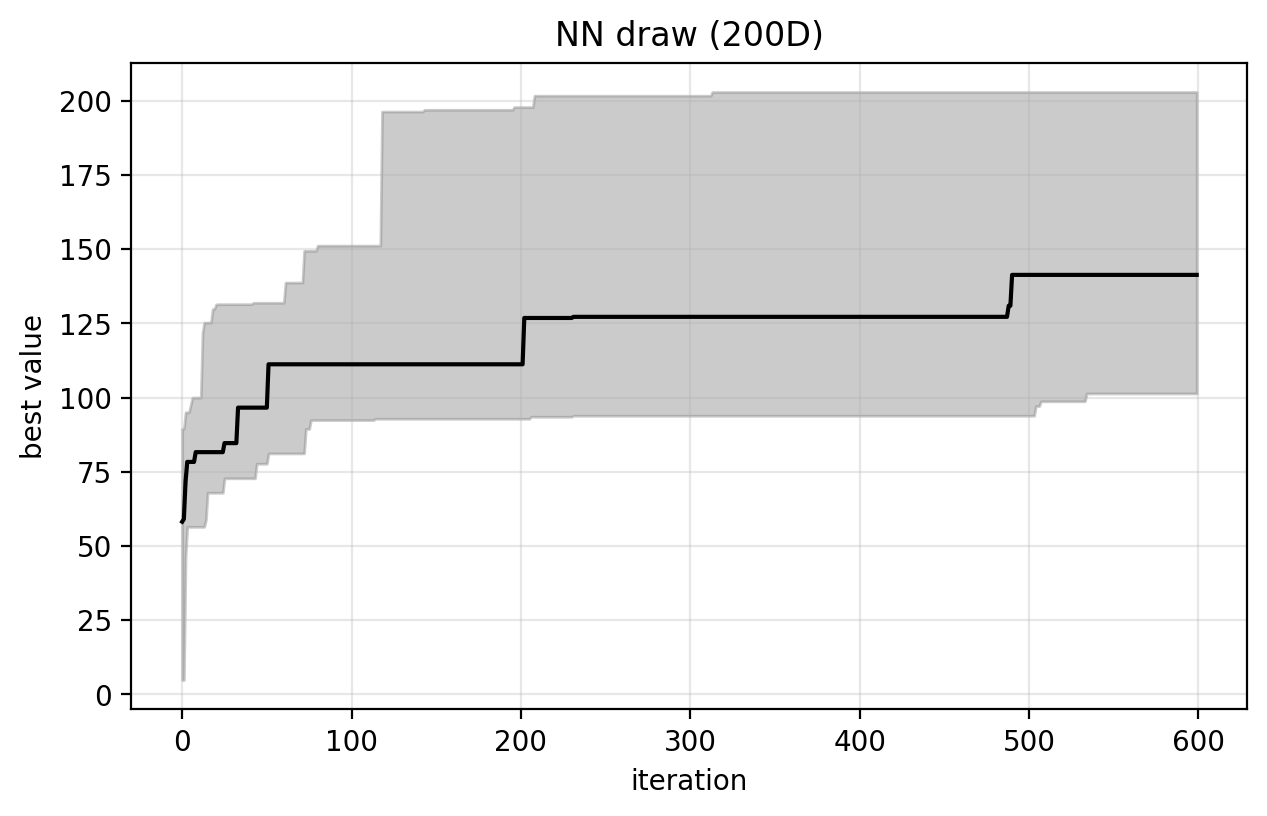

In [35]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lofi_null["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Comparison

In [36]:
colors = sns.color_palette()

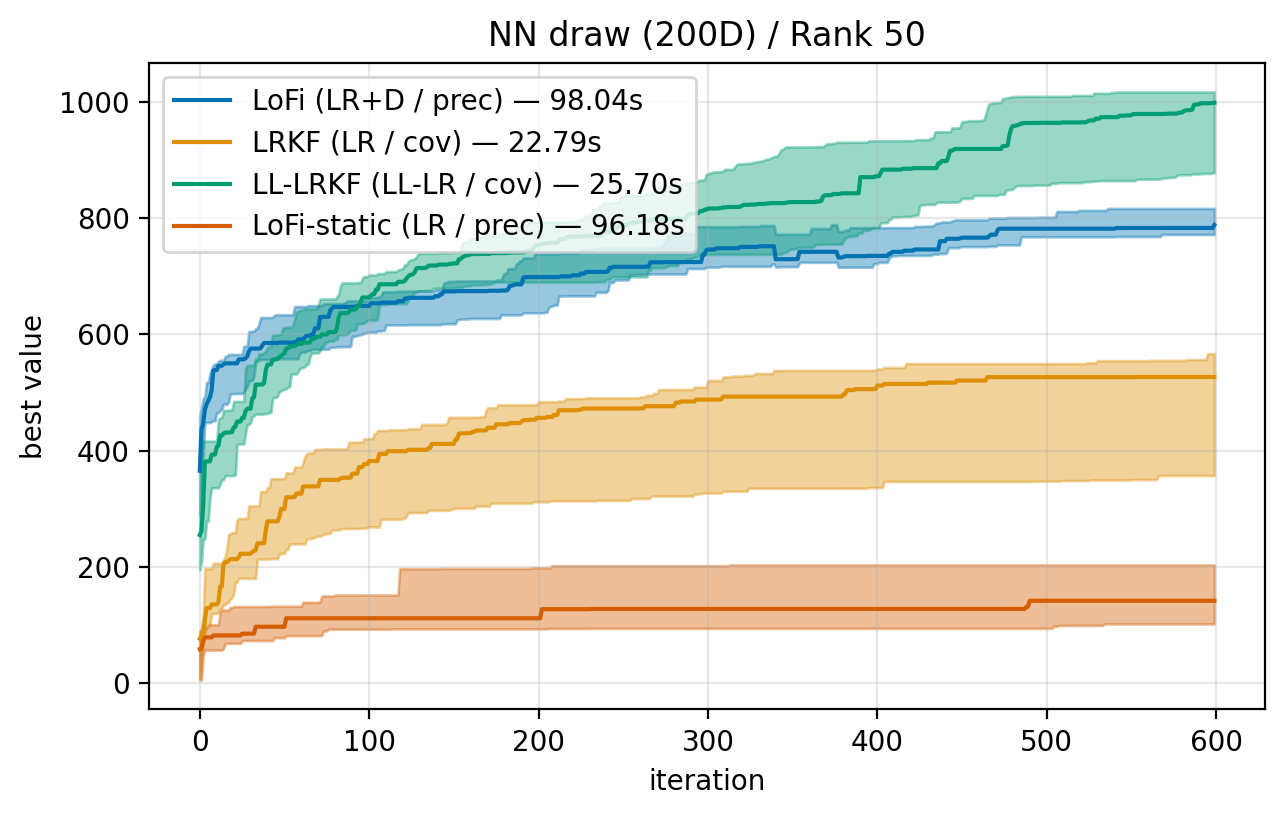

In [43]:
fig, ax = plt.subplots()
plot_hist(ax, runs_lofi["y_best"], label=f"LoFi (LR+D / prec) — {time_lofi:0.2f}s", color=colors[0])
plot_hist(ax, runs_lrkf["y_best"], label=f"LRKF (LR / cov) — {time_lrkf:0.2f}s",  color=colors[1])
plot_hist(ax, runs_l3rkf["y_best"], label=f"LL-LRKF (LL-LR / cov) — {time_l3rkf:0.2f}s",  color=colors[2])
plot_hist(ax, runs_lofi_null["y_best"], label=f"LoFi-static (LR / prec) — {time_lofi_null:0.2f}s", color=colors[3])
plt.title(f"NN draw ({dim}D) / Rank {rank}")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend()
plt.grid(alpha=0.3)

* LRKF sucks but its fast
* LoFi works much better, but it's slow
* LL-LRKF has comparable speed to LRKF, but its the top performing method

## LRKF 

In [44]:
%%time
ranks = [1, 10, 50, 100, 150, 200, 300, 500]

n_steps = 600
n_runs = 10
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)

runs_all = {}
times_all = {}
for rank in ranks:
    print(rank, end="\r")
    agent, bel_init_fn = agents.load_lrkf_agent(
        X_init, rank=rank, cov=1.0, obs_noise=0.1, dynamics_cov=1, low_rank_diag=False,
    )
    time_init = time()
    
    runs_lrkf = eval_fn.test_runs(
        keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim
    )
    runs_lrkf = jax.tree.map(np.array, runs_lrkf)
    time_lrkf = time() - time_init
    
    runs_all[rank] = runs_lrkf
    times_all[rank] = time_lrkf

CPU times: user 8min 13s, sys: 24.3 s, total: 8min 37s
Wall time: 5min 46s


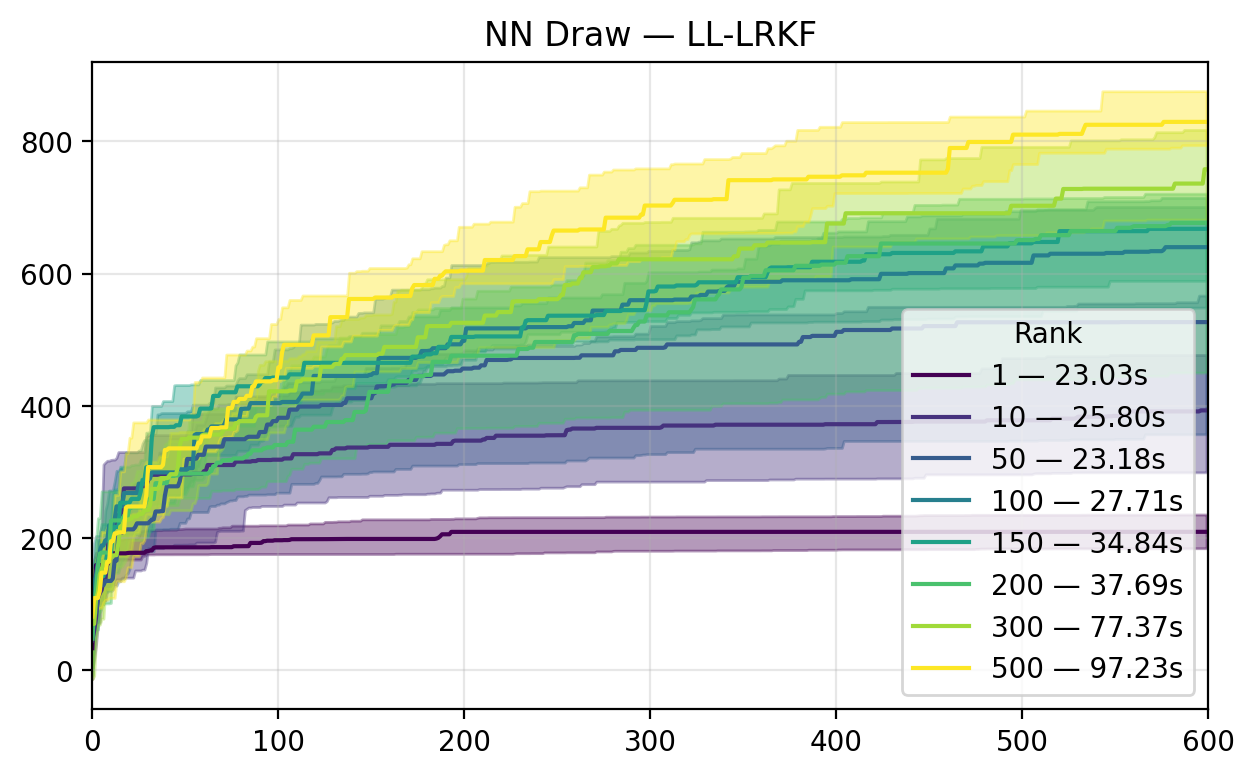

In [45]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, rank, in zip(colors, ranks):
    seconds = times_all[rank]
    plot_hist(ax, runs_all[rank]["y_best"], color=color, label=f"{rank} — {seconds:0.2f}s")
# plot_hist(ax, runs["y_best"], label=f"LoFi (LR+D / prec) — {time_lofi:0.2f}s", color="black")
plt.legend(title="Rank", ncols=1)
# plt.ylim(bottom=800)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LL-LRKF")
plt.grid(alpha=0.3)

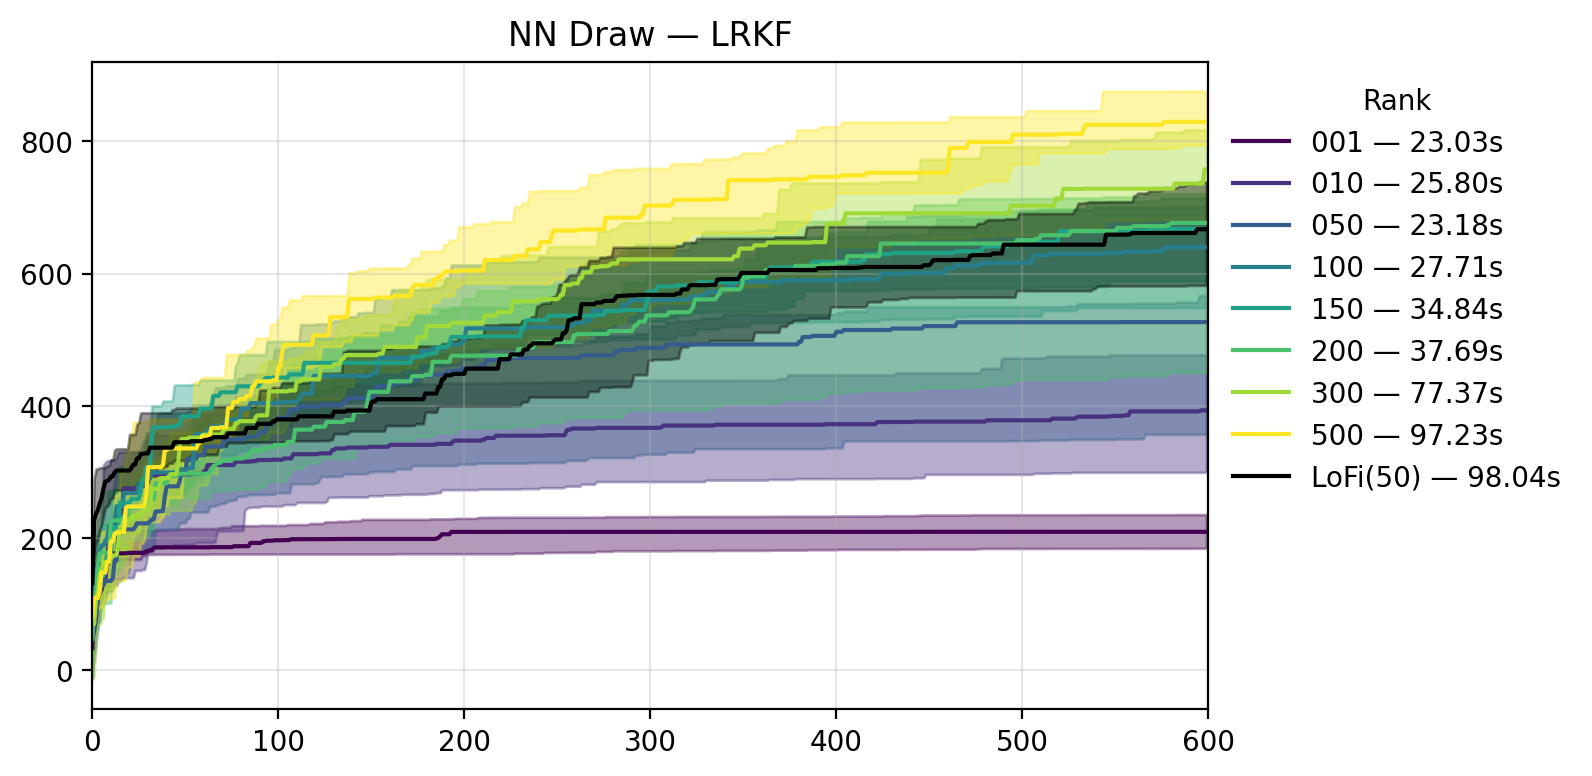

In [46]:
fig, ax = plt.subplots()

colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
for color, rank, in zip(colors, ranks):
    seconds = times_all[rank]
    plot_hist(ax, runs_all[rank]["y_best"], color=color, label=f"{rank:03} — {seconds:0.2f}s")
plot_hist(ax, runs["y_best"], label=f"LoFi(50) — {time_lofi:0.2f}s", color="black")
plt.legend(title="Rank", ncols=1, bbox_to_anchor=(1,1), frameon=False)
# plt.ylim(bottom=800)
plt.xlim(left=0.0, right=n_steps)
plt.title("NN Draw — LRKF")
plt.grid(alpha=0.3)